In [15]:
from utils_cv import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import collections
import time
from skimage import io
from skimage.feature import canny
from skimage.transform import rescale
from skimage.morphology import dilation, disk

%matplotlib inline

from IPython import display

from scipy.ndimage import distance_transform_edt

In [ ]:
ДОБАВИТЬ ПРОВЕРКУ ЧТО КОНТУР НАЙДЕН И ВМЕНЯЕМ, ИНАЧЕ НЕ ВЫДАВАТЬ НИЧЕГО 
ДОБАВИТЬ ВОЗМОЖНСТЬ С РАЗНЫХ РАКУРСОВ РАССМАТРИВАТЬ 


In [19]:
files = np.array(os.listdir('data/'))
index = ['.jpg' in i for i in files]
paths = ['data/'+i for i in files[index]]

In [180]:
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in read_images(paths)]

In [181]:
grayscale_images = [cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY) for i in range(len(images))]

In [182]:
len(images)

5

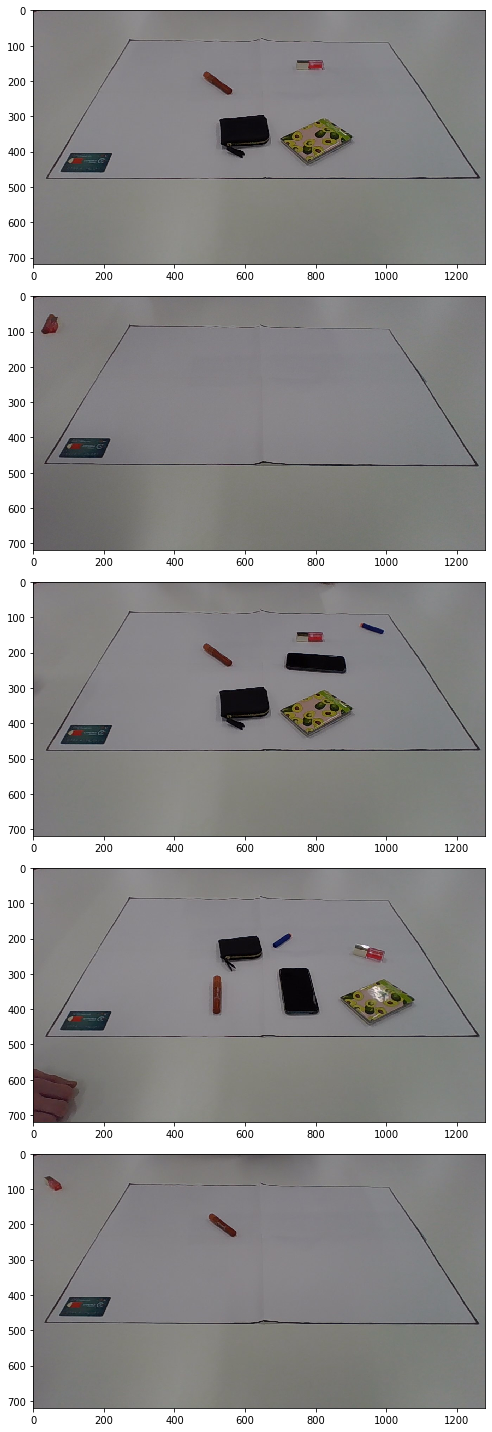

In [183]:
print_images(images, 5, 1)

In [316]:
def normalize_image(image, image_colored, rescale_param = 0.5):
    image_scaled = rescale(image, rescale_param)
    edges = canny(image_scaled)
    
    selem = disk(1)
    edges = dilation(edges, selem)
    
    edges = (edges).astype(np.uint8)
    _, ext_contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(ext_contours, key=cv2.contourArea)
    contour = contour.squeeze()
    epsilon = 0.05 * cv2.arcLength(contour, True)
    corners = cv2.approxPolyDP(contour, epsilon, True).squeeze()
    
#     print(corners)
    
    a = corners[np.argsort(corners[:, 0])]
    first = a[:2]
    first =(first[np.argsort(first[:, 1])])
    second = a[2:]
    second = (second[np.argsort(second[:, 1])])
    corners = np.vstack([first, second])
    corners = corners/rescale_param
    
#     plt.figure(figsize = (4, 4), dpi = 180)
#     plt.imshow(image, cmap = 'gray')
#     plt.scatter(corners[:, 0][0], corners[:, 1][0], c = 'r')
#     plt.scatter(corners[:, 0][1], corners[:, 1][1], c = 'b')
#     plt.scatter(corners[:, 0][2], corners[:, 1][2], c = 'c')
#     plt.scatter(corners[:, 0][3], corners[:, 1][3], c = 'g')
    
#     print(corners.astype('int32'))
    size_square = min(image_scaled.shape)
    tform = ProjectiveTransform()
    tform.estimate(np.array([[0,0], [0, 720], [1020,0], [1020,720]]), corners)
    image_warped = warp(image_colored, tform)[:720,:1020]
    
    
#     info = np.info(image_warped.dtype)
    data = image_warped.astype(np.float64) / np.max(image_warped)
    data = 255 * data # Now scale by 255
    img = data.astype(np.uint8)
    img = adjusting_brightness(img[30:-5, 15:-15], a = 1.5, b = 3)
    return img

In [330]:
n = 0
image_redone = normalize_image(grayscale_images[n], images[n], rescale_param = 0.6)

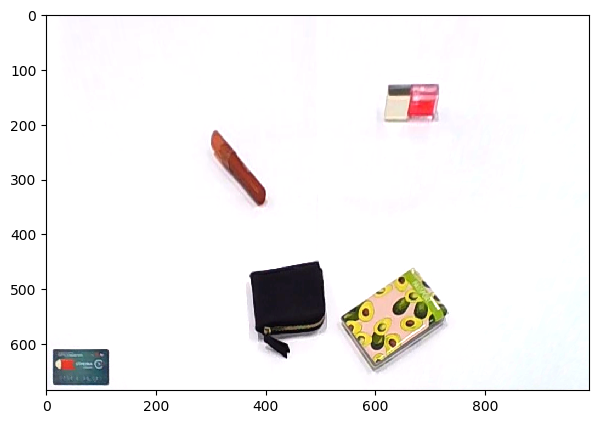

In [331]:
show(image_redone)

In [339]:
image = cv2.cvtColor(image_redone, cv2.COLOR_RGB2GRAY)

In [364]:
rescale_param = 0.1

In [371]:
image_scaled = rescale(image, rescale_param)
edges = canny(image_scaled)

selem = disk(1)
edges = dilation(edges, selem)

edges = (edges).astype(np.uint8)
ext_contours = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(ext_contours)
(cnts, _) = contours.sort_contours(cnts)
cnts = [cnt[:, 0]/rescale_param for cnt in cnts]
pixelsPerMetric = None

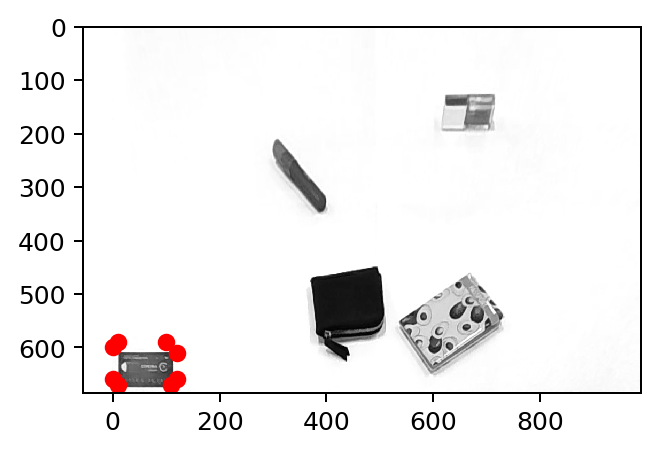

In [373]:
plt.figure(figsize = (4, 4), dpi = 180)
plt.imshow(image, cmap = 'gray')
plt.scatter(cnts[0][:, 0], cnts[0][:, 1], c = 'r')


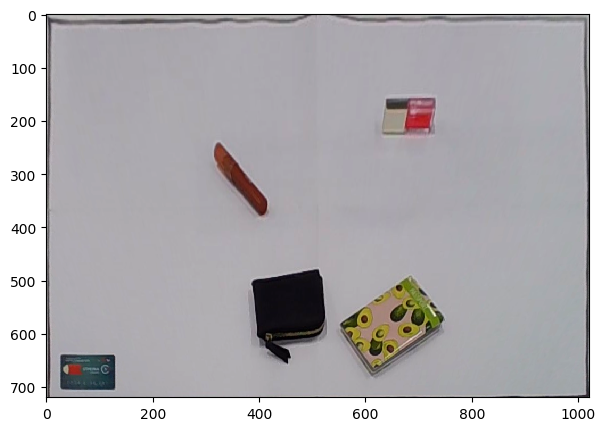

In [232]:
show(image_redone.astype('uint8'))

In [70]:
for image in grayscale_images[:1]:
    image_scaled = rescale(image, 0.4)
    edges = canny(image_scaled)
    selem = disk(1)
    edges = dilation(edges, selem)
    edges = (edges).astype(np.uint8)
    image, ext_contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(ext_contours, key=cv2.contourArea)
    contour = contour.squeeze()
    epsilon = 0.05 * cv2.arcLength(contour, True)
    corners = cv2.approxPolyDP(contour, epsilon, True).squeeze()

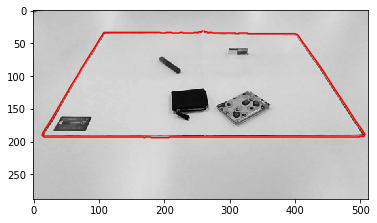

In [71]:
fig, ax = plt.subplots()
ax.imshow(image_scaled, cmap=plt.cm.gray)
ax.plot(contour[:, 0], contour[:,  1], 'r')

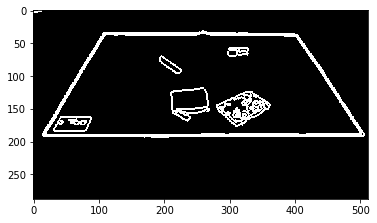

In [60]:
fig, ax = plt.subplots()
ax.imshow(edges, cmap=plt.cm.gray)

for n, contour in enumerate(ext_contours):
    contour = np.array(contour).squeeze()
    if contour.ndim > 1:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=2)

In [5]:
# but this works somehow

video_capture = cv2.VideoCapture(0)
frames = []
# while video_capture.isOpened():
for i in range(10):
    ret, frame = video_capture.read()
    frames.append(frame)
    if ret:
        #cv2.imshow('Video', frame)
        display.clear_output(wait=True)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY), cmap = 'gray')
        plt.show()
        time.sleep(0.002)
        
        k = cv2.waitKey(33) & 0xff
        if  k == 27: 
            break
    else:
        break
video_capture.release()
# cv2.destroyAllWindows()

In [ ]:
# Create a VideoCapture object and read from input file
# If the input is taken from the camera, pass 0 instead of the video file name.
 
cap = cv2.VideoCapture('chaplin.mp4')

In [1]:
size = 5, 8